In [14]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 5, 9), datetime.date(2022, 5, 7))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,APSG,2.178348
2,AZEK,1.491984
3,ASL,1.336702
4,AFI,1.278004


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=B">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'bki bmac bsaq bsm bb bfz bcat bhk hyt btz dsu ecat '
    'bgr cii bdj boe egf bgy fra bgt bme bmez blk bkt bigz bkn blw '
    'bta bit mua muc mhd mfl muj mhn mue '
    'mvt mvf myc miy myj myn mpa mqt myi mqy btt mui '
    'bym bfk ble bny bcx bst bstz bsd bbn bui bhv')
SYMBOLS = sym.split()
#SYMBOLS

In [7]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  59 of 59 completed

1 Failed download:
- BSD: No data found, symbol may be delisted


,bki,bmac,bsaq,bsm,bb,bfz,bcat,bhk,hyt,btz,...,bfk,ble,bny,bcx,bst,bstz,bsd,bbn,bui,bhv
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-09,11.91,11.392371,NaN,6.199745,3.474960,8.516768,9.375278,10.076100,7.754947,3.250129,...,9.586491,8.384168,9.931265,9.033486,5.967573,9.477451,9.705743,8.590670,9.379777,8.595961
2012-05-10,11.80,11.448385,NaN,6.186196,3.489064,8.511109,9.381289,10.134711,7.706444,3.250129,...,9.604577,8.366784,10.003361,9.045013,5.995695,9.488714,9.723804,8.643154,9.402920,8.589940
2012-05-11,11.80,11.649199,NaN,6.145558,3.465554,8.528177,9.374034,10.092843,7.851668,3.219260,...,9.622149,8.409881,9.962332,9.076292,6.006442,9.534611,9.753453,8.679493,9.382000,8.620796
2012-05-14,11.80,11.638952,NaN,6.059762,3.442041,8.488352,9.398207,9.929587,7.781226,3.170752,...,9.567615,8.380764,9.968363,9.047330,5.978162,9.523278,9.717156,8.661912,9.411137,8.602647
2012-05-15,11.10,11.480143,NaN,5.955908,3.427935,8.522485,9.398207,9.753769,7.618663,3.135471,...,9.579739,8.380764,9.920090,9.018366,6.006442,9.472286,9.771602,8.661912,9.463581,8.596596


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])
    
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_43394/2417818282.py:8: RuntimeWarning: Mean of empty slice.
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  

,stock,sharpe
35,mue,0.751066
20,bme,0.729690
28,bit,0.720738
18,fra,0.708608
21,bmez,0.695747
4,bb,0.661350
14,bdj,0.645884
29,mua,0.529788
33,muj,0.526218
32,mfl,0.512109


In [11]:
sharpes = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ascending=False)
    .drop_duplicates())
sharpes.head(20)

,stock,sharpe
0,ASAN,4.146624
1,APSG,2.178348
2,AZEK,1.491984
3,ASL,1.336702
4,AFI,1.278004
5,AMT,1.139614
6,ASH,1.124632
7,APA,1.034629
8,APN,1.025721
9,ARCH,0.996203


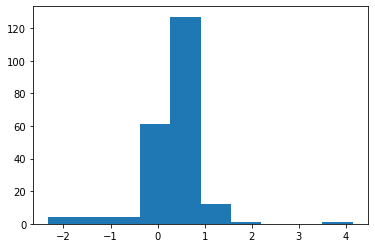

In [12]:
plt.hist(sharpes.sharpe);

In [13]:
sharpes.to_csv('sharpes.csv', index=False)

In [31]:
sharpes.shape

(215, 2)

In [32]:
MIX = sharpes.stock.tolist()[:100]
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
df.columns = MIX
df = df.dropna(axis=1)
print(df.shape)
df.head()

[*********************100%***********************]  100 of 100 completed
(2516, 55)


,ASL,AFI,AMT,ASH,APA,ARCH,AZZ,ATA,AIC,AVD,...,dsu,ABG,cii,AAC,AP,ACC,AXR,bgt,AMCR,ATAQ
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-09,12.138660,30.700274,4.807300,26.020000,18.266962,30.872377,17.730366,28.384727,7.285923,24.829590,...,9.466828,6.123313,5.881923,7.930414,3.119118,18.410467,7.967746,8.384168,9.033484,9.477451
2012-05-10,12.096316,31.186228,4.805840,26.530001,18.412766,30.791033,17.919622,28.438696,7.168827,25.468189,...,9.496770,6.151615,5.867780,7.978511,3.125037,18.398876,7.955721,8.366783,9.045012,9.488719
2012-05-11,11.884595,31.220329,4.754839,26.070000,18.283157,30.803333,17.979389,28.168875,7.199187,24.974022,...,9.549172,6.132748,5.948900,8.062847,3.107281,18.433659,8.005872,8.409883,9.076295,9.534606
2012-05-14,11.623472,31.245892,4.630977,25.760000,18.121147,30.482323,17.710445,28.114910,7.212197,25.126080,...,9.213399,6.076135,5.920439,7.950045,3.065851,18.375675,8.017953,8.380760,9.047328,9.523282
2012-05-15,11.609359,31.032764,4.612034,25.840000,18.428974,30.605255,17.491306,27.953018,7.186176,24.816538,...,9.228660,6.047830,5.891973,7.805010,3.018502,18.410467,8.042129,8.380760,9.018368,9.472291


In [34]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

AFI   : 0.08002
ARI   : 0.16631
fra   : 0.27798
AEO   : 0.12055
AORT  : 0.06592
ATIP  : 0.03279
mfl   : 0.25645


In [35]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 20.8%
Annual volatility: 16.8%
Sharpe Ratio: 1.12
